In [53]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd

In [54]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device="cpu"
print(f"Using {device} device")

Using cuda device


In [135]:
# Downsampling the Point cloud
import numpy as np
import time


def voxel_downsample(point_cloud, voxel_size):
    # Find the minimum and maximum bounds of the point cloud
    min_bound = np.min(point_cloud, axis=0)
    max_bound = np.max(point_cloud, axis=0)
    
    # Calculate voxel indices
    voxel_indices = np.floor_divide(point_cloud - min_bound, voxel_size).astype(int)
    
    # Create a unique identifier for each voxel
    unique_voxels, inverse_indices = np.unique(voxel_indices, axis=0, return_inverse=True)
    
    # Calculate voxel centroids
    voxel_centroids = np.zeros((unique_voxels.shape[0], 3))
    voxel_counts = np.zeros(unique_voxels.shape[0])
    
    for i, voxel_index in enumerate(unique_voxels):
        voxel_points = point_cloud[(inverse_indices == i)]
        voxel_centroids[i] = np.mean(voxel_points, axis=0)
        voxel_counts[i] = len(voxel_points)
    
    return voxel_centroids, voxel_counts

#Helper function to read .pcd File
def read_pcd_file(file_path):
    """
    Read a .pcd file and return the point cloud.
    """
    with open(file_path, 'r') as f:
        lines = f.readlines()

    data_start = False
    data = []

    for line in lines:
        if line.startswith('DATA'):
            data_start = True
            continue
        if data_start:
            data.append(list(map(float, line.split())))

    point_cloud = np.array(data)

    return point_cloud

points = np.random.rand(1460, 3)  # Sample point cloud
voxel_size = 0.1

start=time.time()
downsampled_points = voxel_downsample(points, voxel_size)
end=time.time()

print("Normal : ",end-start)



start=time.time()
point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(points)
downsampled_points = point_cloud.voxel_down_sample(voxel_size=voxel_size)
end=time.time()

print("By Open3d : ",end-start)


# print(downsampled_points.shape)

Normal :  0.023870468139648438
By Open3d :  0.00040078163146972656


In [107]:
import json

data=[]

# data_file = './labels.json'
data_file = './full_dataset/converted.json'

using = "pandas"


if(using=="json"):
    # Load JSON data from the file
    with open(data_file) as f:
        data = json.load(f)
    print(data[1]['time'])
else:
    data =pd.read_json(data_file)
    print(data.head())

          time                                              chair  \
0  00:00.00000  [[-0.1140332378, -1.0363261758, 0.0844578892, ...   
1  00:00.08103  [[-0.1087164686, -1.0356720574, 0.0847318111, ...   
2  00:00.15946  [[-0.1033996995, -1.035017939, 0.085005733, 1....   
3  00:00.23964  [[-0.09808293030000001, -1.0343638205, 0.08527...   
4  00:00.31915  [[-0.09276616110000001, -1.0337097021, 0.08555...   

                                               stool  \
0  [[2.1505855001, -1.4536903501, 0.1369566768, 1...   
1  [[2.1473772297, -1.4468101854, 0.1367251761, 1...   
2  [[2.1441689593, -1.4399300207, 0.1364936754000...   
3  [[2.1409606889, -1.4330498561, 0.1362621746, 1...   
4  [[2.1377524185, -1.4261696914, 0.1360306739, 1...   

                                               table  \
0  [[0.1156135214, -2.2455869696, 0.1178784221, 1...   
1  [[0.1152638103, -2.2443210638, 0.117856133, 1....   
2  [[0.11491409920000001, -2.243055158, 0.1178338...   
3  [[0.114564388, -2.241

In [108]:
#Remove Mis-aligend Files
for item in ["chair","stool","table","wall"]:
    for index,i in enumerate(data[item]):
        if type(i)== dict:
            data=data.drop(index)

In [109]:
#Check for mis-alligen Files
for item in ["chair","stool","table","wall"]:
    for index,i in enumerate(data[item]):
        if type(i)== dict:
            print(index)

In [143]:
import open3d as o3d
import numpy as np

def readPCDFile(fileName):
    fileName =fileName.replace(":","_")
#     pcd_path = f"data_set/{fileName}.pcd"
    pcd_path = f"full_dataset/pcd/{fileName}.pcd"
    point_cloud = o3d.io.read_point_cloud(pcd_path)
    point_cloud = point_cloud.voxel_down_sample(voxel_size=0.086)
    output=torch.from_numpy(np.asarray(point_cloud.points)).float()
    output=torch.nn.functional.pad(output, (0, 0, 0, 1600 - output.size(0)))
    output = output.to(device=device)
    return output
readPCDFile("00:00.08103").shape

torch.Size([1600, 3])

In [140]:
import open3d as o3d
import numpy as np
import time

def readPCDFile(fileName):
    fileName =fileName.replace(":","_")
#     pcd_path = f"data_set/{fileName}.pcd"
    pcd_path = f"full_dataset/pcd/{fileName}.pcd"
    point_cloud = read_pcd_file(pcd_path)
    point_cloud = voxel_downsample(point_cloud,voxel_size=0.086)
#     point_cloud = point_cloud.voxel_down_sample(voxel_size=0.086)
    output=torch.from_numpy(point_cloud).float()
#     output=torch.from_numpy(np.asarray(point_cloud.points)).float()
    output=torch.nn.functional.pad(output, (0, 0, 0, 1600 - output.size(0)))
    output = output.to(device=device)
    return output
readPCDFile("00:00.08103").shape

TypeError: expected np.ndarray (got tuple)

In [142]:
class CustomDataset(Dataset):
    
    def __init__(self, data):
        self.labels=data

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx] if using=="json" else self.labels.iloc[idx]
        point_cloud_data = readPCDFile(label['time'])
        label_data=torch.tensor(label['chair'],device=device)
        return [point_cloud_data, label_data]

In [99]:
dataset = CustomDataset(data=data)
dataset_loader = DataLoader(dataset, batch_size=1, shuffle=True)

In [100]:
dataset_loader.dataset[0]

[tensor([[ 32.1687, -18.3864,   3.2417],
         [ -0.5897,   2.7161,   0.2432],
         [ -0.1999,   3.2694,   0.2866],
         ...,
         [  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000]], device='cuda:0'),
 tensor([[-0.1140, -1.0363,  0.0845,  1.8055,  1.1400,  0.4269,  0.0000,  0.0000,
           0.0000],
         [ 1.2384, -3.4363,  0.1242,  1.2163,  1.3069,  0.7050,  0.0000,  0.0000,
           0.0000],
         [ 3.2114, -3.2485,  0.1857,  0.9632,  1.1087,  0.9266,  0.0000,  0.0000,
          48.5323],
         [ 5.4827,  0.1195,  0.1603,  1.7691,  1.9000,  0.9465,  0.0000,  0.0000,
           0.0000]], device='cuda:0')]

In [144]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork,self).__init__()
        self.model=nn.Sequential(
#           # Define convolutional layers
            nn.ReLU(),
            nn.Conv1d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.MaxPool1d(kernel_size=16, stride=2),
            nn.Conv1d(in_channels=16, out_channels=16, kernel_size=4, padding=1),
            nn.Linear(792,16),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(16,1),
            nn.Flatten(),
        )
        self.prob=nn.Sequential(
            nn.ReLU(),
            nn.Linear(16,32),
            nn.Linear(32,10),
            nn.ReLU(),
            nn.Softmax(dim=1)
        )
        self.boxes=nn.Sequential(
            nn.ReLU(),
            nn.Linear(16,32),
            nn.Linear(32,128),
            nn.ReLU(),
            nn.Linear(128,90)
        )
       
    def forward(self,x):
        
        base = self.model(x)
        _base = base.clone()
        prob = self.prob(base)
        boxes = self.boxes(_base).view(-1, 10,9)
        return prob,boxes
        

In [145]:


model = NeuralNetwork().to(device)
print(model)

criterion = nn.MSELoss()
criterion_prob = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



NeuralNetwork(
  (model): Sequential(
    (0): ReLU()
    (1): Conv1d(3, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (2): MaxPool1d(kernel_size=16, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(16, 16, kernel_size=(4,), stride=(1,), padding=(1,))
    (4): Linear(in_features=792, out_features=16, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=16, out_features=1, bias=True)
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (prob): Sequential(
    (0): ReLU()
    (1): Linear(in_features=16, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=10, bias=True)
    (3): ReLU()
    (4): Softmax(dim=1)
  )
  (boxes): Sequential(
    (0): ReLU()
    (1): Linear(in_features=16, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=90, bias=True)
  )
)


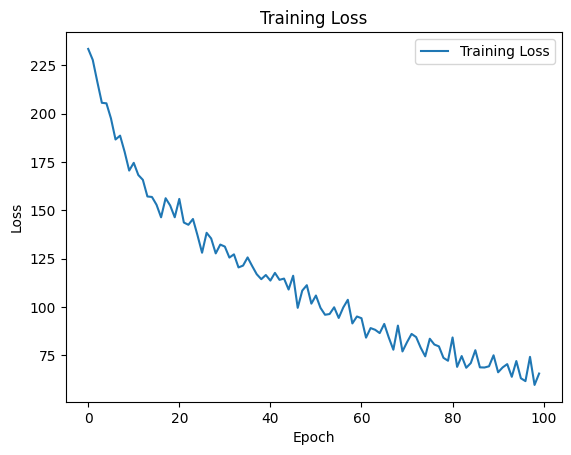

Finished Training


In [147]:
import matplotlib.pyplot as plt


def pad_labels(label, max_len=10):
    if len(label[0])>0 :
        pad_width=max_len-len(label[0])
        padded_label = torch.nn.functional.pad(label, (0, 0, 0,pad_width,0,0))
        return padded_label
    else:
        return torch.zeros(1,10,9,device=device)

loss_values = []

for epoch in range(100):
    running_loss = 0.0
    
    for i, _data in enumerate(dataset_loader, 0):
#         if(i>50):
#             break
        try:
            inputs, labels = _data
            optimizer.zero_grad()
            prob, boxes = model(inputs.transpose(1, 2))
            loss = criterion(boxes, pad_labels(labels.float()))
            prob_test = np.zeros((1, 10))
            prob_test[0, :len(labels[0])] = 1 / (len(labels[0]) if len(labels[0])>0 else 1 )
            loss_prob = criterion_prob(prob, torch.tensor(prob_test, device=device))
            total_loss =  loss_prob+loss
            total_loss.backward()
            optimizer.step()
            running_loss += total_loss.item()
        
        except:
            print("Exception Occured at "+i)
            pass
        # Update statistics
       
    loss_values.append(running_loss/len(dataset_loader.dataset))
    if epoch % 1 == 0:  # Print every 10 mini-batches
        print('[%d / 100] loss: %.3f' % (epoch + 1, running_loss/len(dataset_loader.dataset) ), end="\r", flush=True)


# Plot the loss function
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


print('Finished Training')


In [148]:
#Save Model
torch.save(model, "deepNeuralNetwork.pth")


## Validation

In [151]:
# Validation

test_data = data.iloc[300:500]
test_dataset = CustomDataset(data=test_data)
test_dataset_loader = DataLoader(dataset, batch_size=1, shuffle=True)
dataset_loader.dataset[0]

[tensor([[ 32.1687, -18.3864,   3.2417],
         [ -0.5897,   2.7161,   0.2432],
         [ -0.1999,   3.2694,   0.2866],
         ...,
         [  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000]], device='cuda:0'),
 tensor([[-0.1140, -1.0363,  0.0845,  1.8055,  1.1400,  0.4269,  0.0000,  0.0000,
           0.0000],
         [ 1.2384, -3.4363,  0.1242,  1.2163,  1.3069,  0.7050,  0.0000,  0.0000,
           0.0000],
         [ 3.2114, -3.2485,  0.1857,  0.9632,  1.1087,  0.9266,  0.0000,  0.0000,
          48.5323],
         [ 5.4827,  0.1195,  0.1603,  1.7691,  1.9000,  0.9465,  0.0000,  0.0000,
           0.0000]], device='cuda:0')]

Validation Accuracy: 87 %
Validation Loss: 1390.8807645936795


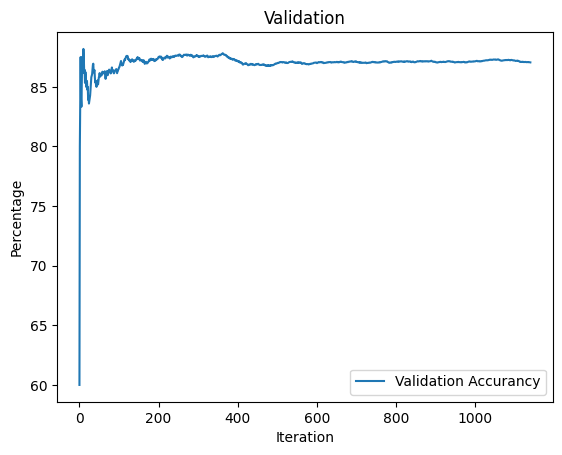

In [162]:
correct = 0                                               
total = 0                                                 
running_loss = 0.0                                        
model.eval()  
validation_loss=[]
validation_accurancy=[]

with torch.no_grad():                                     
    for Ti, _Tdata in enumerate(test_dataset_loader):                     
        inputs, labels = _Tdata  
        
        prob, boxes = model(inputs.transpose(1, 2))
        
        loss = criterion(boxes, pad_labels(labels.float()))
        
        prob_test = np.zeros((1, 10))
        prob_test[0, :len(labels[0])] = 1 / (len(labels[0]) if len(labels[0])>0 else 1 )
        
        loss_prob = criterion_prob(prob, torch.tensor(prob_test, device=device))
        total_loss =  loss_prob+loss    
        
        validation_loss.append(loss.item())

        _, predicted = torch.max(prob, 1)         
        total += 10
        correct += (predicted ==  torch.tensor(prob_test, device=device)).sum().item()     
        
        validation_accurancy.append(100 * correct / total)
        
        running_loss = running_loss + loss_prob.item()         
mean_val_accuracy = (100 * correct / total)               
mean_val_loss = ( running_loss )                  
#mean_val_accuracy = accuracy(outputs,labels)             
print('Validation Accuracy: %d %%' % (mean_val_accuracy)) 
print('Validation Loss:'  ,mean_val_loss )  



# Plot the loss function
# plt.plot(validation_loss, label='Validation Loss')
plt.plot(validation_accurancy, label='Validation Accurancy')
plt.xlabel('Iteration')
plt.ylabel('Percentage')
plt.title('Validation')
plt.legend()
plt.show()


plt.show()




In [159]:
model.eval()
with torch.no_grad():
    prediction = model(readPCDFile("00:07.99279").unsqueeze(0).transpose(1,2))
    print(prediction)
# print(readPCDFile("00:07.99279").unsqueeze(0).shape)

(tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0'), tensor([[[-2.1170e+00, -2.7767e+00,  8.1624e-01,  1.2713e+00,  6.2862e-01,
           3.3701e+00, -2.6620e-01,  5.6165e-01,  4.1347e+01],
         [ 1.8441e+00, -3.9906e+00, -1.0520e-01,  6.9124e-01, -1.4490e+00,
           4.8809e-01, -1.1434e+00, -1.0959e+00,  2.6295e+02],
         [ 3.0273e+00,  2.5094e+00, -1.2396e+00,  1.0309e+00,  6.4626e-01,
           9.3296e-01,  1.0344e-02, -3.5453e-01,  4.8829e+01],
         [-6.4628e-01, -6.5048e-01,  4.7242e-01,  1.8346e-01,  2.5993e-02,
          -3.4764e-01, -4.3901e-02, -7.9123e-01, -1.1693e-01],
         [-2.0361e-01,  1.6955e-01, -5.5682e-02, -1.1992e-01, -8.1150e-01,
           1.8261e-01,  3.1684e-02, -7.2994e-01,  8.1255e-02],
         [-1.6638e+00,  3.1550e-01,  2.1253e-01,  4.5805e-01, -2.2306e+00,
          -6.6467e-01, -3.0462e-01,  2.1034e+00, -2.1990e-01],
         [-8.1882e-01,  4.8609e-01,  1.8215e-01, -2.4735e-01, -6.3630e-01,
          -7.4311e-01, -2.6